I think that it should be possible to "diff" models like Anthropic does in their crosscoder paper, without training a crosscoder! 

We can think of a transformer $T$ as a function from an activation vector to a piece of text in semantic space. Defining addition in this semantic space is kind of tricky, but we say that if we add together two pieces of text that are "happy", we get a piece of text that is happier.

From the initial paper on sparse autoencoders, we know that for two feature vectors $U, V$:

$T(U + V) \approx T(U) + T(V)$

Take this approx with a huge grain of salt, but we can then say that this transformer is a linear map between the SAE feature space and the semantic space.

If for two different transformers $T_1, T_2$ acting on activation spaces $A_1, A_2$, we can find a linear map from $A_1$ to $A_2$ that best aligns the two models, and because the transformer is linear, this alignment should be pretty good! We can then look at where this alignment fails and use that to understand differences between the two models.

This linear map from $A_1$ to $A_2$ is like a change of basis between the two model activation spaces.

Basically, you can find a transformation between the features of one model and the features of another model, and where this transformation fails is where the two models have the most difference.

In this post / notebook, I show emperical evidence that this may be possible!

## Method

The method is as follows:

I first learn a linear map between activation spaces $A_1$ and $A_2$ of two different models $T_1, T_2$. I do this by collecting a dataset of activation vectors from each model on the same pieces of text, and learn the linear map $R$ that best converts between the two activation spaces.

I then take the features that form the basis for the feature spaces $F_1, F_2$. We can convert all the features in $F_1$ to the $F_2$ space using the linear map $R$, but I don't know correspondence between the features in $F_1$ and $F_2$. Thus, I use the linear assignment solver / hungarian algorithm to find the best permutation of the features in $F_1$ that minimizes the distance to the features in $F_2$. 

I take this alignment for granted, and say that it is perfect. Then, we can say that this is basically the same thing as the crosscoder vector, and just like the crosscoder we can look at the encoder norms to the permuted features in $F_1$ and the encoder norms to the features in $F_2$. Where these differ the most is the features where the models have the most difference.

In order to test this, I use the self-interp method introduced in [Self-explaining SAE Features (Kharlapenko et al.)](https://www.alignmentforum.org/posts/8ev6coxChSWcxCDy8/self-explaining-sae-featuress). This is not ideal, and having the dashboards for this SAE would be best, but I don't have access to this.

## Implementation

I provide a lot of code here. Feel free to skip to the section "Conclusions" if you want to see the results.

We first generate the data for points to align.



In [ ]:
raise Exception("""This code isn't meant to be run with the rest of the code. 
                It generates the data for the rest of the code, and this seems
                bad to run again everytime you want to do the experiment.
                Comment this out!""")

from transformer_lens import HookedTransformer
from datasets import load_dataset
from tqdm import tqdm
import torch

torch.set_grad_enabled(False)

device = "mps"
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

gemma_2b_it = HookedTransformer.from_pretrained(
    "gemma-2b-it",
    torch_dtype=torch.bfloat16, 
).to(device)
dataset = load_dataset("allenai/c4", "en", split="train", streaming=True)
dataset_iter = iter(dataset)
first_500_points = [next(dataset_iter)["text"] for _ in range(500)]
tokens = gemma_2b_it.to_tokens(
    first_500_points, prepend_bos=True, padding_side="left", move_to_device=True
).detach()[:, :2048]

# prepare hooks
gemma_2b_activations = []
gemma_2b_it_activations = []

print(tokens.shape)

def gemma_2b_hook(activations, hook):
    act = activations[..., -1, :].detach().cpu()  # Keep on GPU
    gemma_2b_activations.append(act)

def gemma_2b_it_hook(activations, hook):
    act = activations[..., -1, :].detach().cpu()  # Keep on GPU
    gemma_2b_it_activations.append(act)

# Run inference
BATCH_SIZE = 5
for i in tqdm(range(0, len(tokens), BATCH_SIZE)):
    batch = tokens[i:i + BATCH_SIZE]
    ans = gemma_2b_it.run_with_hooks(
        batch,
        fwd_hooks=[("blocks.12.hook_resid_post", gemma_2b_it_hook)],
    )
    del ans
    torch.cuda.empty_cache()

del gemma_2b_it
torch.cuda.empty_cache()

# Load second model to GPU with bf16
gemma_2b = HookedTransformer.from_pretrained(
    "gemma-2b",
    torch_dtype=torch.bfloat16
).to(device)

for i in tqdm(range(0, len(tokens), BATCH_SIZE)):
    batch = tokens[i:i + BATCH_SIZE]
    ans = gemma_2b.run_with_hooks(
        batch,
        fwd_hooks=[("blocks.12.hook_resid_post", gemma_2b_hook)],
    )
    del ans
    torch.cuda.empty_cache()
# concatenate activations (still on GPU)
gemma_2b_activations = torch.cat(gemma_2b_activations, dim=0)
gemma_2b_it_activations = torch.cat(gemma_2b_it_activations, dim=0)

del tokens, gemma_2b
torch.cuda.empty_cache()

# Move to CPU only when saving
torch.save(gemma_2b_activations, "similarity_of_sae_dir/gemma_2b_activations.pt")
torch.save(gemma_2b_it_activations, "similarity_of_sae_dir/gemma_2b_it_activations.pt")

Now, we load this dataset and learn the linear map between the two activation spaces.

In [1]:
import torch
import numpy as np
from sae_lens import SAE
from transformer_lens import HookedTransformer
from numpy.linalg import norm

gemma_2b_activations = torch.load("similarity_of_sae_dir/gemma_2b_activations.pt", weights_only=True).float().cpu().numpy()
gemma_2b_it_activations = torch.load("similarity_of_sae_dir/gemma_2b_it_activations.pt", weights_only=True).float().cpu().numpy()

print(gemma_2b_activations.shape, gemma_2b_it_activations.shape)

(500, 2048) (500, 2048)


In [2]:
# First compute A^T A with regularization term
lambda_reg = 1.0  # L2 regularization strength
n_features = gemma_2b_activations.shape[1]
ATA = gemma_2b_activations.T @ gemma_2b_activations + lambda_reg * np.eye(n_features)

# Then compute A^T B 
ATB = gemma_2b_activations.T @ gemma_2b_it_activations

# Solve for R with regularization
R = np.linalg.solve(ATA, ATB)

# Compute the transformed activations
transformed_activations = gemma_2b_activations @ R

# Calculate error
error = np.mean((transformed_activations - gemma_2b_it_activations) ** 2)
print(f"Mean squared error: {error}")

# Print the frobenius norm of the error
frobenius_norm_error = norm(transformed_activations - gemma_2b_it_activations, "fro")
print(f"Frobenius norm of error: {frobenius_norm_error}")

# Print the frobenius norm of R to check if regularization helped
print(f"Frobenius norm of R: {norm(R, 'fro')}")


Mean squared error: 3.2549355296672035e-12
Frobenius norm of error: 0.0018256653533382547
Frobenius norm of R: 0.24972663642939782


Now, we load the SAEs and get the features.

In [3]:
import matplotlib.pyplot as plt
from sae_lens import SAE
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA
import numpy as np
import torch

# disable gradients
torch.set_grad_enabled(False)

gemma_2b_sae, gemma_2b_cfg, gemma_2b_sparsity = SAE.from_pretrained(
    release="gemma-2b-res-jb",
    sae_id="blocks.12.hook_resid_post",
    device="mps"
)

gemma_2b_it_sae, gemma_2b_it_cfg, gemma_2b_it_sparsity = SAE.from_pretrained(
    release="gemma-2b-it-res-jb",
    sae_id="blocks.12.hook_resid_post",
    device="mps"
)


In [4]:
gemma_2b_dec = gemma_2b_sae.W_dec.detach().cpu().numpy()
gemma_2b_it_dec = gemma_2b_it_sae.W_dec.detach().cpu().numpy()

gemma_2b_enc = gemma_2b_sae.W_enc.detach().cpu().numpy()
gemma_2b_it_enc = gemma_2b_it_sae.W_enc.detach().cpu().numpy()

m_A = gemma_2b_dec.shape[0]
m_B = gemma_2b_it_dec.shape[0]
n = gemma_2b_dec.shape[1]

print(gemma_2b_dec.shape, gemma_2b_it_dec.shape)
print(len(gemma_2b_dec), len(gemma_2b_it_dec))

(16384, 2048) (16384, 2048)
16384 16384


We can apply this learnt lienar map to the SAE features, and then learn a permutation that best aligns the two sets of features. *Warning*: This takes a while to run, because learning the permutation sucks.

In [5]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
import torch

# Convert numpy arrays to torch tensors on MPS
transformed_features = gemma_2b_dec @ R
instruct_features = gemma_2b_it_dec
transformed_features_t = torch.from_numpy(transformed_features.astype(np.float32)).to('mps')
instruct_features_t = torch.from_numpy(instruct_features.astype(np.float32)).to('mps')

# Calculate pairwise distances between all features using torch
distances = torch.zeros((transformed_features.shape[0], instruct_features.shape[0]), device='mps')
for i in tqdm(range(transformed_features.shape[0])):
    # Vectorize inner loop by broadcasting
    diff = transformed_features_t[i:i+1] - instruct_features_t
    distances[i] = torch.norm(diff, dim=1)

# Move distances back to CPU for linear_sum_assignment
distances = distances.cpu().numpy()

# Find optimal assignment that minimizes total distance
row_ind, col_ind = linear_sum_assignment(distances)

# Create permutation matrix from the assignment
permutation = torch.zeros((len(row_ind), len(col_ind)), device='mps')
for i, j in zip(row_ind, col_ind):
    permutation[i,j] = 1

# Apply permutation to get aligned features
aligned_features = permutation @ transformed_features_t

# Calculate error after alignment
error_after_alignment = torch.mean((aligned_features - instruct_features_t) ** 2).item()
print(f"Mean squared error after alignment: {error_after_alignment}")

# Store the permutation indices for later use with encoder
permutation_indices = col_ind

print("First few permutation mappings:")
for i in range(min(10, len(row_ind))):
    print(f"Feature {i} maps to feature {permutation_indices[i]}")


100%|██████████| 16384/16384 [00:52<00:00, 311.27it/s]


Mean squared error after alignment: 0.0008108550100587308
First few permutation mappings:
Feature 0 maps to feature 8785
Feature 1 maps to feature 8580
Feature 2 maps to feature 2406
Feature 3 maps to feature 5323
Feature 4 maps to feature 1309
Feature 5 maps to feature 9431
Feature 6 maps to feature 5123
Feature 7 maps to feature 6775
Feature 8 maps to feature 1934
Feature 9 maps to feature 1510


Now, we take the norms to this common basis, and see where the largest differences are.

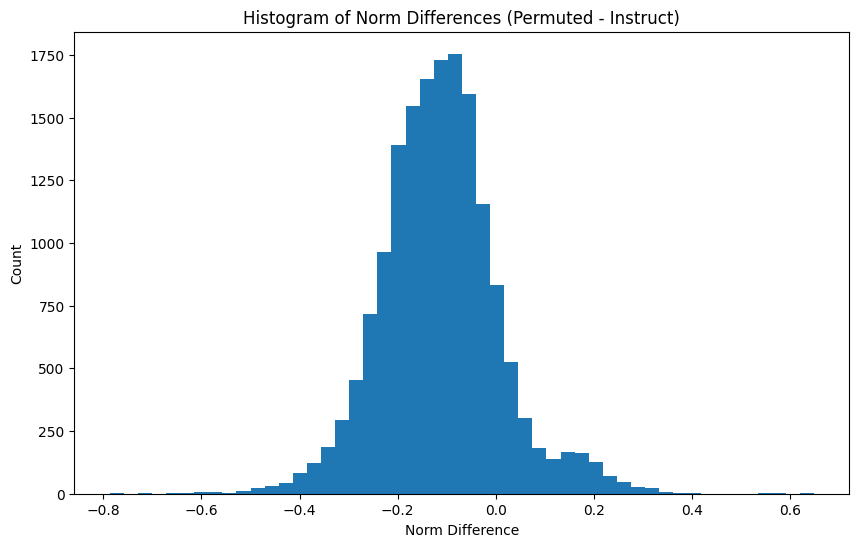

Mean absolute norm difference: 0.1373
Max absolute norm difference: 0.7869
Min absolute norm difference: 0.0000
Largest positive differences (index, value):
4988 -> 10841: 0.6487
4424 -> 5233: 0.5897
1722 -> 8731: 0.5539
11453 -> 1589: 0.3922
12141 -> 4834: 0.3907
16381 -> 16317: 0.3683
10706 -> 14482: 0.3635
15868 -> 15497: 0.3632
1365 -> 9630: 0.3552
8682 -> 1547: 0.3484

Largest negative differences (index, value):
12816: -0.7869
13319: -0.7215
1551: -0.6639
13208: -0.6596
4503: -0.6468
6440: -0.6290
14235: -0.6024
2982: -0.6017
6278: -0.6017
16007: -0.5942


In [7]:
# Get encoder norms in permuted space
encoder_weights = gemma_2b_enc.T
permuted_encoder_norms = np.linalg.norm(encoder_weights[permutation_indices], axis=1) / np.max(np.linalg.norm(encoder_weights[permutation_indices], axis=1))

# Get encoder norms in instruct space
instruct_encoder_norms = np.linalg.norm(gemma_2b_it_enc.T, axis=1) / np.max(np.linalg.norm(gemma_2b_it_enc.T, axis=1))

# Calculate differences in norms
norm_differences = permuted_encoder_norms - instruct_encoder_norms

# Plot histogram of norm differences
plt.figure(figsize=(10,6))
plt.hist(norm_differences, bins=50)
plt.title('Histogram of Norm Differences (Permuted - Instruct)')
plt.xlabel('Norm Difference')
plt.ylabel('Count')
plt.show()

# Print some statistics
print(f"Mean absolute norm difference: {np.mean(np.abs(norm_differences)):.4f}")
print(f"Max absolute norm difference: {np.max(np.abs(norm_differences)):.4f}")
print(f"Min absolute norm difference: {np.min(np.abs(norm_differences)):.4f}")

# get the indices of the largest positive norm differences
# and the largest negative norm differences
largest_positive_indices = np.argsort(norm_differences)[::-1]
largest_negative_indices = np.argsort(norm_differences)

print("Largest positive differences (index, value):")
for idx in largest_positive_indices[:10]:
    print(f"{idx} -> {permutation_indices[idx]}: {norm_differences[idx]:.4f}")

print("\nLargest negative differences (index, value):")
for idx in largest_negative_indices[:10]:
    print(f"{idx}: {norm_differences[idx]:.4f}")

We have identified the largest positive and negative diffences. For reference, positive differences are features that exist in the base model, while negative differences are features that exist in the instruct model.

```
Positive: [ 4988  4424  1722 11453 12141]
Negative: [12816 13319  1551 13208  4503]
```

In [1]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch

gemma_2b_model = HookedTransformer.from_pretrained("gemma-2b", device="mps", dtype=torch.bfloat16)
gemma_2b_sae, cfg_dict, _ = SAE.from_pretrained(
    release="gemma-2b-res-jb", sae_id="blocks.12.hook_resid_post", device="mps"
)

positive_outputs = []
negative_outputs = []

steering_coeff = 100
prompt = "The meaning of X"
instruct_prompt = "What is the meaning of X?"
def steer_with_feature(feature_index: int, prompt: str, model: HookedTransformer, sae: SAE) -> str:
    steering_vector = sae.W_dec[feature_index]
    def steering_hook(resid_post, hook):
        if resid_post.shape[1] == 1:
            return

        resid_post[:, 4, :] += steering_coeff * steering_vector
        return resid_post
    
    sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)
    with model.hooks(fwd_hooks=[("blocks.12.hook_resid_post", steering_hook)]):
        tokenized = model.to_tokens(prompt, prepend_bos=True)
        result = model.generate(
            stop_at_eos=False, # avoids a bug on MPS
            input=tokenized,
            max_new_tokens = 30,
            do_sample=True,
            **sampling_kwargs
        )
        return f"Steering with feature {feature_index}: {''.join(model.to_str_tokens(result[0])[1:])}"

def steer_with_feature_instruct(feature_index: int, prompt: str, model: HookedTransformer, sae: SAE) -> str:
    steering_vector = sae.W_dec[feature_index]
    def steering_hook(resid_post, hook):
        if resid_post.shape[1] == 1:
            return

        resid_post[:, 9, :] += 1000 * steering_vector
        return resid_post
    
    sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)
    with model.hooks(fwd_hooks=[("blocks.12.hook_resid_post", steering_hook)]):
        tokenized = model.to_tokens(
            model.tokenizer.apply_chat_template(
                [{"role": "user", "content": prompt}], 
                tokenize=False
            ), prepend_bos=False
        )
        result = model.generate(
            stop_at_eos=False, # avoids a bug on MPS
            input=tokenized,
            max_new_tokens = 30,
            do_sample=True,
            **sampling_kwargs
        )
        return f"Steering with feature {feature_index}: {''.join(model.to_str_tokens(result[0])[1:])}"
    
for i in [10841, 5233, 8731, 1589, 4834, 16317, 14482, 15497, 9630, 1547]:
    positive_outputs.append(steer_with_feature(i, prompt, model=gemma_2b_model, sae=gemma_2b_sae))

del gemma_2b_model # free up memory

gemma_2b_it = HookedTransformer.from_pretrained("gemma-2b-it", device="mps", dtype=torch.bfloat16)
gemma_2b_it_sae, cfg_dict, _ = SAE.from_pretrained(
    release="gemma-2b-it-res-jb", sae_id="blocks.12.hook_resid_post", device="mps"
)

for i in [12816, 13319, 1551, 13208, 4503, 6440, 14235, 2982, 6278, 16007]:
    negative_outputs.append(steer_with_feature_instruct(i, instruct_prompt, model=gemma_2b_it, sae=gemma_2b_it_sae))

del gemma_2b_it_sae # free up memory
del gemma_2b_it # free up memory

print("ONLY IN BASE MODEL:")
print(("\n" + "*" * 100 + "\n").join(positive_outputs))
print("\n\n")
print("*" * 100)
print("\n\n")
print("ONLY IN INSTRUCT MODEL:")
print(("\n" + "*" * 100 + "\n").join(negative_outputs))


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b-it into HookedTransformer


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

ONLY IN BASE MODEL:
Steering with feature 10841: The meaning of X<bos><h1>X-ray diffraction</h1>

<b>X-ray diffraction</b> is a technique used to determine the structure of crystals. It was discovered by Max
****************************************************************************************************
Steering with feature 5233: The meaning of X<bos><h1>How to get the current page URL in a custom module?</h1>

I'm trying to create a custom module that will display the current
****************************************************************************************************
Steering with feature 8731: The meaning of X<bos><h1>How to get the current time in a specific timezone</h1>

I'm trying to get the current time in a specific timezone. I have
****************************************************************************************************
Steering with feature 1589: The meaning of X want to be the same as the meaning of 1.

The first is a person who wants to be a star, an